In [1]:

from dgm_network import DGMNet
from trainer import DGMTrainer, DGMTrainer_2D
from visualize import *
from data_sampling import *
from utility_functions import *


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Deep Galerkin Method with Heat Equation in 1D (Time Dependent)

In [2]:
lx_1d = 2.0
T_max = 2.0
bounds_1d = [[0.0, lx_1d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01
PDE_CONSTANTS = {'alpha': ALPHA}

# Data Sizes
N_INT = 1000
N_IC = 600
N_BC =300

## Functions to implement the internal and boundary conditions

## Data Preparation

In [3]:
# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
x_int, t_int = generate_domain_points(N_INT, bounds_1d, T_max)
f_tx = source_term_fn_1D(t_int, x_int, ALPHA).to(device)
interior_data_1d = (t_int, x_int, f_tx)

# 2. Initial Condition Data (t = 0, x in [0, lx_1d])
x_ic = generate_ic_points(N_IC, bounds_1d).to(device)
t_ic = torch.zeros_like(x_ic[:, 0:1]).to(device)
u_ic = initial_condition_fn_1D(x_ic).to(device)
ic_data_1d = (t_ic, x_ic, u_ic)

# 3. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
x_bc = generate_boundary_points(N_BC, bounds_1d)
t_bc = torch.rand_like(x_bc[:, 0:1]) * T_max # Sample time for boundary points
u_bc = boundary_condition_fn_1D(t_bc, x_bc).to(device)
bc_data_1d = (t_bc, x_bc, u_bc)

## Visualizing the Sampled data

In [4]:
#visualize_points_1d(x_int,x_bc, bounds_1d)

## Neural Network initialization

In [5]:


num_layers = 6
nodes_per_layer = 64
learning_rate = 0.0001
epochs = 5500

model = DGMNet(nodes_per_layer, num_layers, 1).to(device)

trainer = DGMTrainer(
    model=model,
    pde_constants=PDE_CONSTANTS,
    learning_rate=learning_rate
)

## Training

In [6]:
trainer.train(
    epochs=epochs,
    domain_data=interior_data_1d,
    ic_data=ic_data_1d,
    bc_data=bc_data_1d,
    lambda_ic=50.0,
    lambda_bc=50.0,
    resample=True,
    sampling_config={
        'n_int': N_INT,
        'n_ic': N_IC,
        'n_bc': N_BC,
        'bounds': bounds_1d,
        't_max': T_max
    }
)

Starting training on mps. Resampling: True
Epoch 200/5500 | Total Loss: 5.5930 | L_pde: 0.0847 | L_ic: 0.1082 | L_bc: 0.0020
Epoch 400/5500 | Total Loss: 1.1572 | L_pde: 0.0408 | L_ic: 0.0169 | L_bc: 0.0054
Epoch 600/5500 | Total Loss: 0.6303 | L_pde: 0.0196 | L_ic: 0.0065 | L_bc: 0.0057
Epoch 800/5500 | Total Loss: 0.3325 | L_pde: 0.0109 | L_ic: 0.0033 | L_bc: 0.0031
Epoch 1000/5500 | Total Loss: 0.2680 | L_pde: 0.0091 | L_ic: 0.0027 | L_bc: 0.0025
Epoch 1200/5500 | Total Loss: 0.2019 | L_pde: 0.0083 | L_ic: 0.0017 | L_bc: 0.0022
Epoch 1400/5500 | Total Loss: 0.1613 | L_pde: 0.0080 | L_ic: 0.0014 | L_bc: 0.0016
Epoch 1600/5500 | Total Loss: 0.1252 | L_pde: 0.0064 | L_ic: 0.0013 | L_bc: 0.0011
Epoch 1800/5500 | Total Loss: 0.0838 | L_pde: 0.0051 | L_ic: 0.0010 | L_bc: 0.0005
Epoch 2000/5500 | Total Loss: 0.0711 | L_pde: 0.0040 | L_ic: 0.0007 | L_bc: 0.0006
Epoch 2200/5500 | Total Loss: 0.0574 | L_pde: 0.0038 | L_ic: 0.0006 | L_bc: 0.0005
Epoch 2400/5500 | Total Loss: 0.0467 | L_pde: 0.

## Loss History

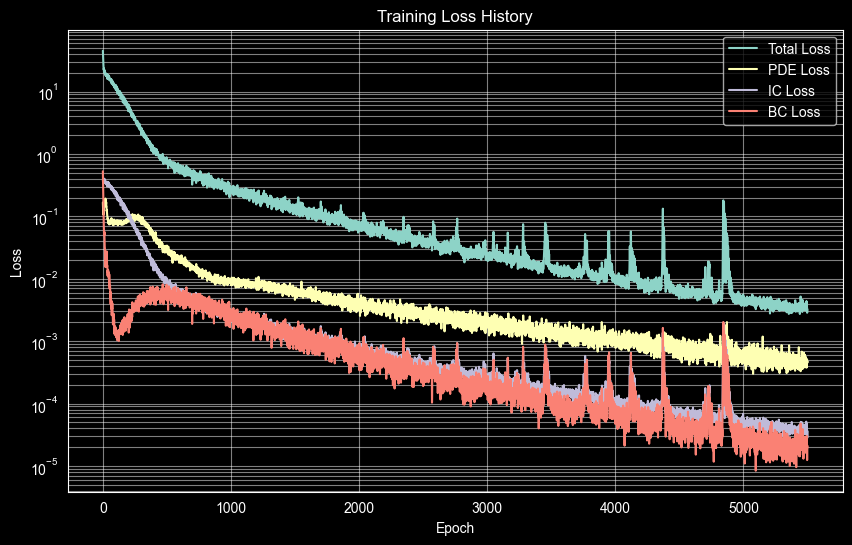

In [7]:
visualize_loss(trainer)

## Quantitative Error Analysis

In [8]:
t_test_time = 2.0
# Calculate relative L2 error at t = t_test_time
# First generate test points
x_test = torch.linspace(0, lx_1d, 1000).reshape(-1, 1).to(device)
t_test = (torch.ones_like(x_test) * t_test_time).to(device)
error = calculate_relative_l2_error(model, t_test, x_test, analytical_solution)
print(f"Relative L2 Error at t={t_test_time}: {error:.4e}")

Relative L2 Error at t=2.0: 1.9277e-02


## Visualization

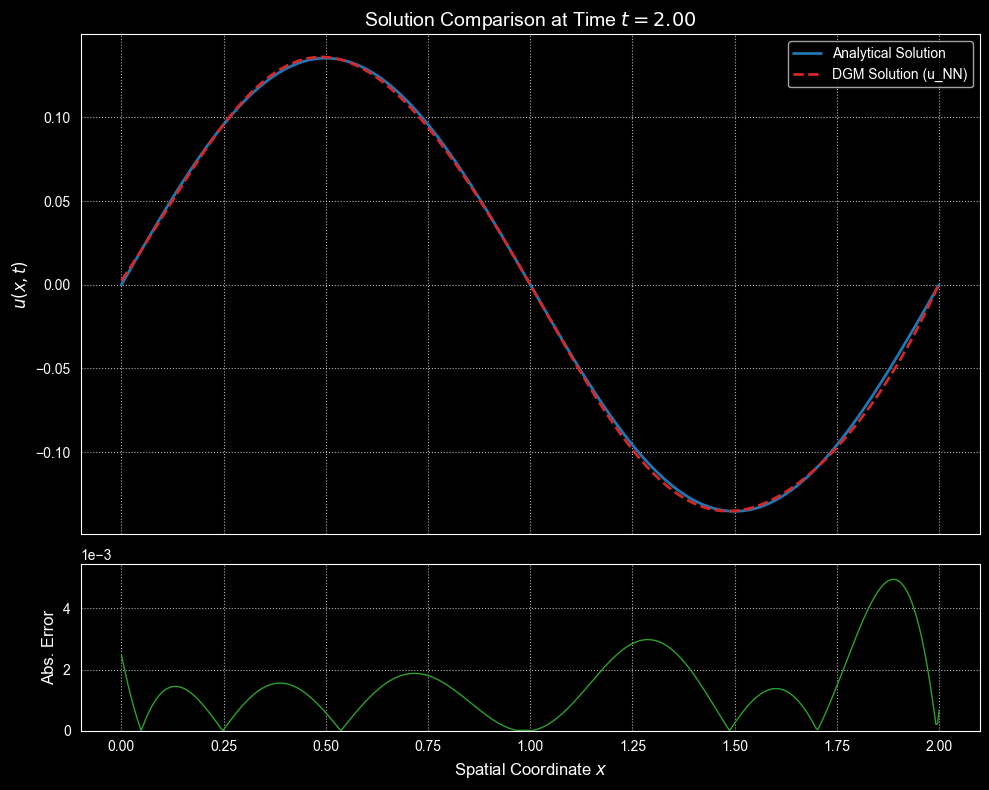

In [9]:
visualize_solution_1d(
    model=model,
    domain_bound=lx_1d,
    t_test=t_test_time,
    n_test_points=500
)

# Deep Galerkin Method in 2D

In [10]:
lx_2d = 2.0
ly_2d = 2.0
T_max = 2.0
bounds_2d = [[0.0, lx_2d],[0.0, ly_2d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01
PDE_CONSTANTS = {'alpha': ALPHA}

# Data Sizes
N_INT = 1500
N_IC = 800
N_BC =400


## Data Preparation

In [11]:

# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
spatial_coords, t_int = generate_domain_points(N_INT, bounds_2d, T_max)
x_int = spatial_coords[:, 0:1]
y_int = spatial_coords[:, 1:2]
f_txy = source_term_fn_2D(t_int, x_int, y_int, ALPHA).to(device)
interior_data = (t_int, x_int, y_int,  f_txy)

# 2. Initial Condition Data (t = 0, x in [0, lx_1d])
spatial_coords_ic = generate_ic_points(N_IC, bounds_2d)
x_ic = spatial_coords_ic[:, 0:1]
y_ic = spatial_coords_ic[:, 1:2]
t_ic = torch.zeros_like(x_ic[:, 0:1]).to(device)
u_ic = initial_condition_fn_2D(x_ic,y_ic).to(device)
ic_data = (t_ic, x_ic, y_ic, u_ic)

# 3. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
spatial_coords_bc = generate_boundary_points(N_BC, bounds_2d)
x_bc = spatial_coords_bc[:, 0:1]
y_bc = spatial_coords_bc[:, 1:2]
t_bc = torch.rand_like(x_bc[:, 0:1]) * T_max # Sample time for boundary points
u_bc = boundary_condition_fn_2D(t_bc, x_bc, y_bc).to(device)
bc_data = (t_bc, x_bc,y_bc, u_bc)

## Visualizing the sampled data

In [12]:
#visualize_points_2d(spatial_coords, spatial_coords_bc, bounds_2d)

## Neural Network Initialization

In [13]:
num_layers = 6
nodes_per_layer = 64
learning_rate = 0.001
epochs = 6000

model = DGMNet(nodes_per_layer, num_layers, 2).to(device)

trainer = DGMTrainer_2D(
    model=model,
    pde_constants=PDE_CONSTANTS,
    learning_rate=learning_rate
)

## Training

In [14]:
trainer.train(
    epochs=epochs,
    domain_data=interior_data,
    ic_data=ic_data,
    bc_data=bc_data,
    lambda_ic=50.0,
    lambda_bc=50.0,
    resample=True,
    sampling_config={
        'n_int': N_INT,
        'n_ic': N_IC,
        'n_bc': N_BC,
        'bounds': bounds_2d,
        't_max': T_max
    }
)

Starting training on mps. Resampling: True
Epoch 200/6000 | Total Loss: 0.4658 | L_pde: 0.0164 | L_ic: 0.0060 | L_bc: 0.0030
Epoch 400/6000 | Total Loss: 0.0784 | L_pde: 0.0093 | L_ic: 0.0009 | L_bc: 0.0005
Epoch 600/6000 | Total Loss: 0.1076 | L_pde: 0.0050 | L_ic: 0.0013 | L_bc: 0.0008
Epoch 800/6000 | Total Loss: 0.0148 | L_pde: 0.0023 | L_ic: 0.0002 | L_bc: 0.0001
Epoch 1000/6000 | Total Loss: 0.0104 | L_pde: 0.0016 | L_ic: 0.0001 | L_bc: 0.0001
Epoch 1200/6000 | Total Loss: 0.0089 | L_pde: 0.0021 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 1400/6000 | Total Loss: 0.0061 | L_pde: 0.0012 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 1600/6000 | Total Loss: 0.0051 | L_pde: 0.0010 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 1800/6000 | Total Loss: 0.0153 | L_pde: 0.0007 | L_ic: 0.0002 | L_bc: 0.0001
Epoch 2000/6000 | Total Loss: 0.0030 | L_pde: 0.0005 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 2200/6000 | Total Loss: 0.0099 | L_pde: 0.0006 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 2400/6000 | Total Loss: 0.0049 | L_pde: 0.

## Loss History

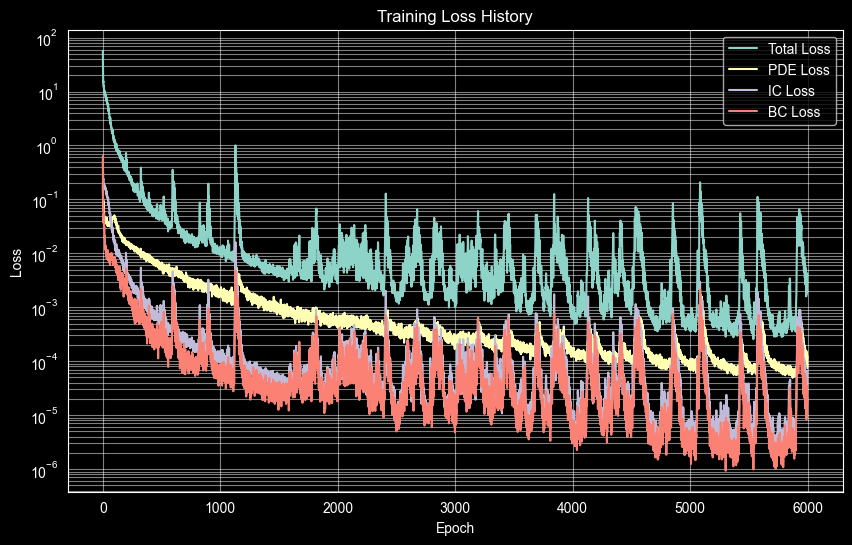

In [15]:
visualize_loss(trainer)

## Quantitative Error Analysis

In [16]:
# Calculate relative L2 error at t = t_test_time
# First generate test points
x_test = torch.linspace(0, lx_2d, 100).to(device)
y_test = torch.linspace(0, ly_2d, 100).to(device)
X, Y = torch.meshgrid(x_test, y_test, indexing='ij')
x_flat = X.reshape(-1, 1)
y_flat = Y.reshape(-1, 1)
t_flat = (torch.ones_like(x_flat) * t_test_time).to(device)
error = calculate_relative_l2_error_2d(model, t_flat, x_flat, y_flat, analytical_solution_2d)
print(f"Relative L2 Error at t={t_test_time}: {error:.4e}")

Relative L2 Error at t=2.0: 9.1354e-02


## Visualization

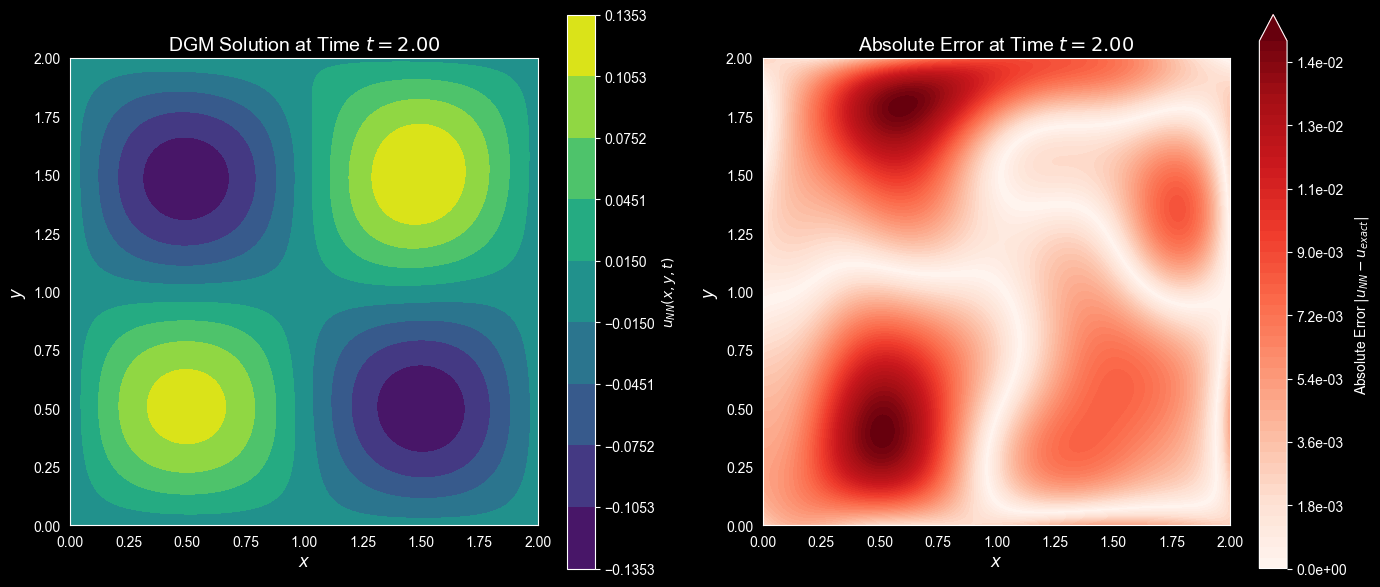

In [17]:
visualize_2d(
    model=model,
    bounds=bounds_2d,
    t_test=t_test_time,
    n_grid=500
)

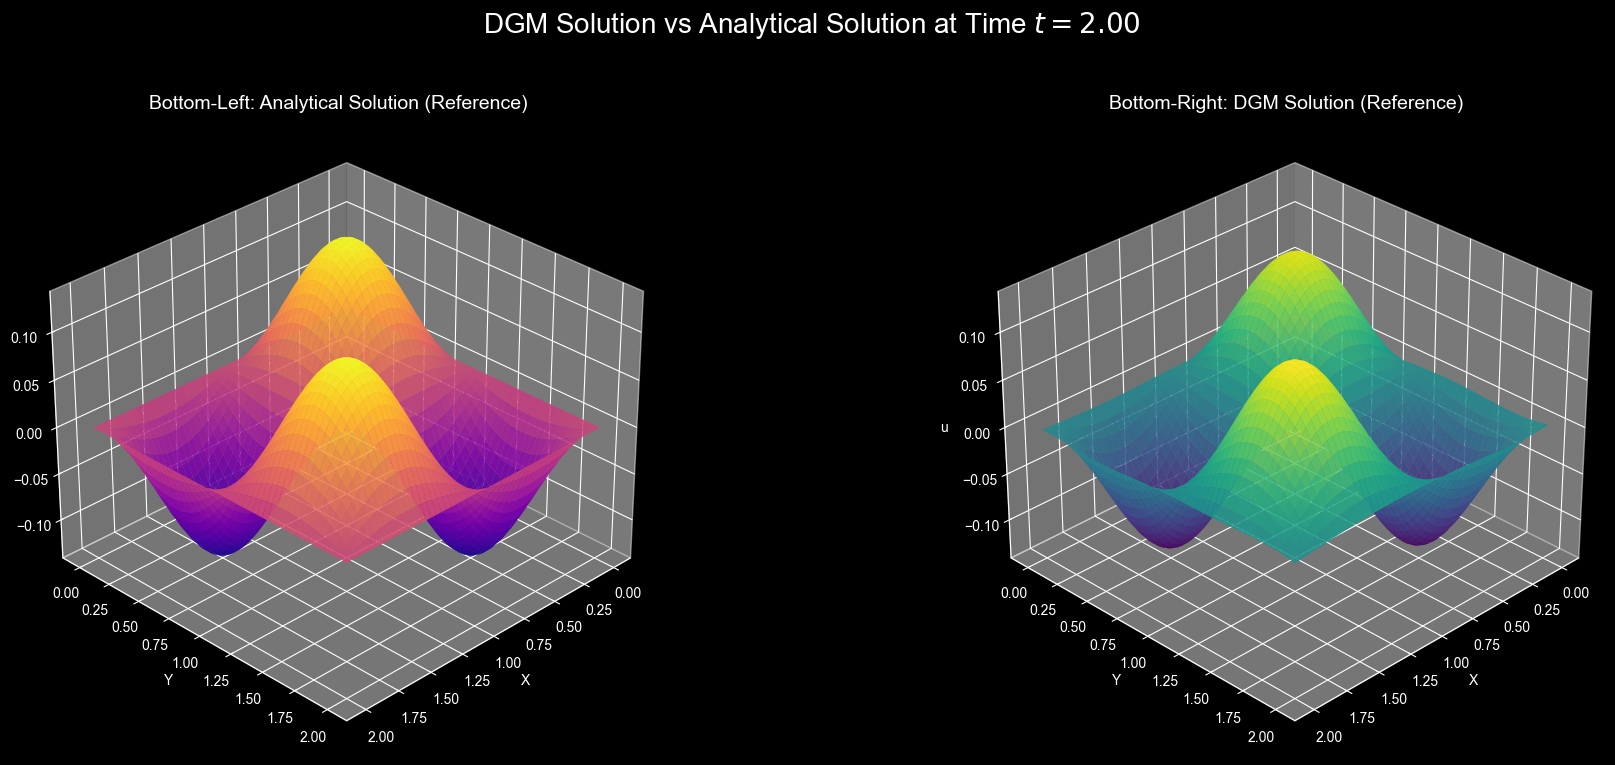

In [18]:
visualize_solution_2d(
    model=model,
    bounds=bounds_2d,
    t_test=t_test_time,
    n_grid=500
)